In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
# Define paths
BASE_DIR = "/content/drive/My Drive/Clothing Segmentation"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoints", "unet_best.h5")
TEST_IMAGES_DIR = os.path.join(BASE_DIR, "dataset", "test", "images")
TEST_MASKS_DIR = os.path.join(BASE_DIR, "dataset", "test", "masks")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "dataset", "labels.csv")

In [19]:
# Load class labels
if os.path.exists(LABELS_CSV_PATH):
    class_df = pd.read_csv(LABELS_CSV_PATH)
    class_names = class_df['label_list'].tolist()
else:
    class_names = [f"Class_{i}" for i in range(59)]  # Default for 59 classes

NUM_CLASSES = len(class_names)

In [10]:
# Load trained U-Net model
model = load_model(MODEL_PATH, compile=False)
print(f"Loaded model from {MODEL_PATH}")


Loaded model from /content/drive/My Drive/Clothing Segmentation/checkpoints/unet_best.h5


In [13]:
# Preprocessing function for images
def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess the input image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    return image

In [14]:
# Function to compute IoU
def calculate_iou(y_true, y_pred, num_classes=NUM_CLASSES):
    """Calculate per-class and mean IoU."""
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    mean_iou = np.mean(ious)
    return ious, mean_iou

In [15]:
# Function to compute Dice coefficient
def dice_coefficient(y_true, y_pred, num_classes=NUM_CLASSES):
    """Calculate per-class and mean Dice coefficient."""
    dice_scores = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        dice = (2 * intersection) / (np.sum(y_true == cls) + np.sum(y_pred == cls)) if (np.sum(y_true == cls) + np.sum(y_pred == cls)) > 0 else 0
        dice_scores.append(dice)
    mean_dice = np.mean(dice_scores)
    return dice_scores, mean_dice

In [16]:
# Function to evaluate model on a single image
def evaluate_single_image(image_path, mask_path):
    """Evaluate segmentation on a single image."""
    original_image = preprocess_image(image_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (256, 256))

    # Predict mask
    input_image = np.expand_dims(original_image, axis=0)
    pred_mask = model.predict(input_image)[0]
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert to class indices

    # Compute Metrics
    ious, mean_iou = calculate_iou(gt_mask, pred_mask)
    dice_scores, mean_dice = dice_coefficient(gt_mask, pred_mask)
    pixel_accuracy = np.mean(gt_mask == pred_mask)

    # Print results
    print(f"\nEvaluation for {os.path.basename(image_path)}:")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU={ious[i]:.4f}, Dice={dice_scores[i]:.4f}")

    # Visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap='tab20b')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='tab20b')
    plt.axis("off")

    plt.show()


In [20]:
# Evaluate on sample images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))
test_masks = sorted(os.listdir(TEST_MASKS_DIR))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Evaluation for img_0007.jpeg:
Mean IoU: 0.0127
Mean Dice Coefficient: 0.0146
Pixel Accuracy: 0.6928
nan: IoU=0.7498, Dice=0.8570
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0000, Dice=0.0000
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0012, Dice=0.0024
dress: IoU=0.0002, Dice=0.0005
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0000
intimate: IoU=0.0000, Dice=0.0000
jacket: IoU=0.0000, Dice=0.0000
jeans: IoU=0.0000, Dice=0.0000
jumper: IoU=0.0000, Dice=0.0000
leggings:

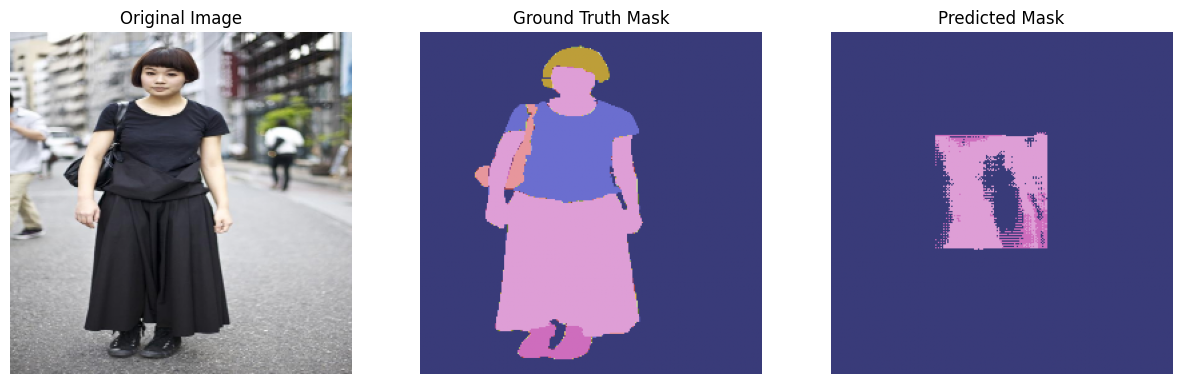

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Evaluation for img_0026.jpeg:
Mean IoU: 0.0145
Mean Dice Coefficient: 0.0156
Pixel Accuracy: 0.7774
nan: IoU=0.8574, Dice=0.9232
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0000, Dice=0.0000
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0000
intimate: IoU=0.0000, Dice=0.0000
jacket: IoU=0.0000, Dice=0.0000
jeans: IoU=0.0000, Dice=0.0000
jumper: IoU=0.0000, Dice=0.0000
leggings:

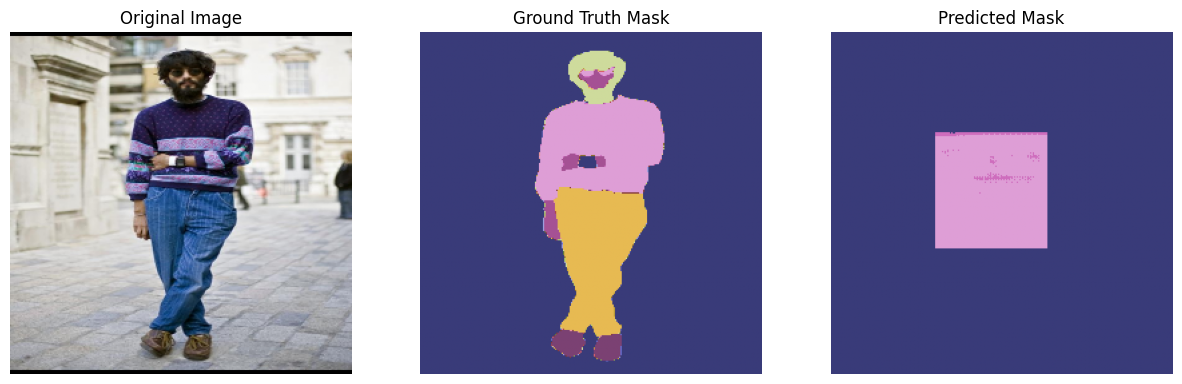

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Evaluation for img_0028.jpeg:
Mean IoU: 0.0141
Mean Dice Coefficient: 0.0154
Pixel Accuracy: 0.7565
nan: IoU=0.8289, Dice=0.9065
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0000, Dice=0.0000
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0007, Dice=0.0013
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0000
intimate: IoU=0.0000, Dice=0.0000
jacket: IoU=0.0000, Dice=0.0000
jeans: IoU=0.0000, Dice=0.0000
jumper: IoU=0.0000, Dice=0.0000
leggings:

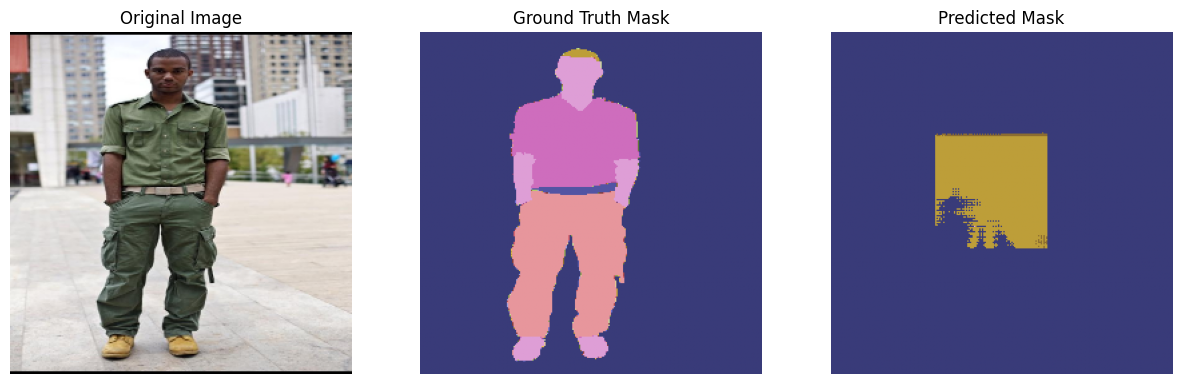

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Evaluation for img_0031.jpeg:
Mean IoU: 0.0213
Mean Dice Coefficient: 0.0255
Pixel Accuracy: 0.8015
nan: IoU=0.8392, Dice=0.9126
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0000, Dice=0.0000
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.4174, Dice=0.5890
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0000
intimate: IoU=0.0000, Dice=0.0000
jacket: IoU=0.0000, Dice=0.0000
jeans: IoU=0.0000, Dice=0.0000
jumper: IoU=0.0000, Dice=0.0000
leggings:

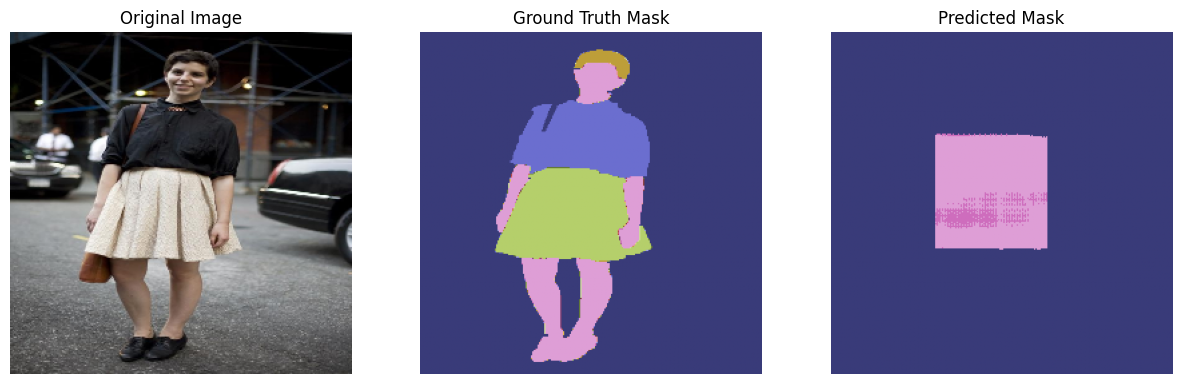

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Evaluation for img_0033.jpeg:
Mean IoU: 0.0146
Mean Dice Coefficient: 0.0157
Pixel Accuracy: 0.7825
nan: IoU=0.8602, Dice=0.9248
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0000, Dice=0.0000
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0003, Dice=0.0005
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0000
intimate: IoU=0.0000, Dice=0.0000
jacket: IoU=0.0000, Dice=0.0000
jeans: IoU=0.0000, Dice=0.0000
jumper: IoU=0.0000, Dice=0.0000
leggings:

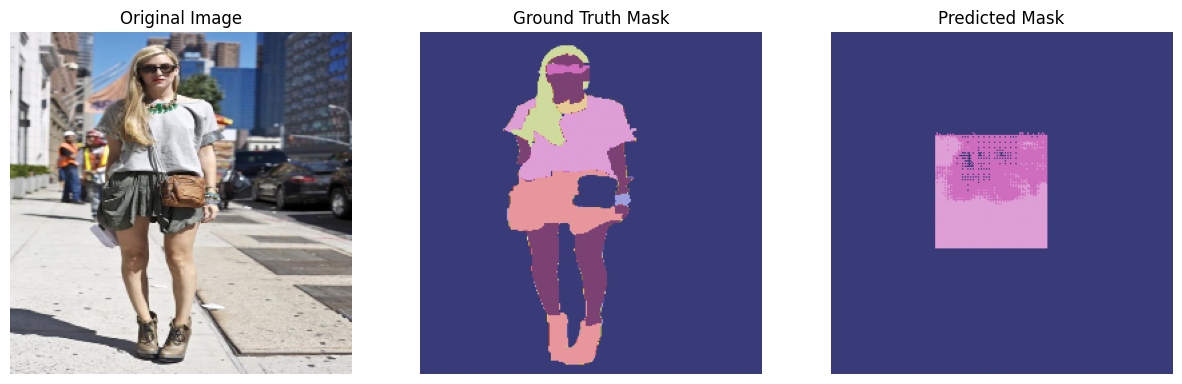

In [21]:
# Pick a few random samples for evaluation
num_samples = min(5, len(test_images))
for i in range(num_samples):
    image_path = os.path.join(TEST_IMAGES_DIR, test_images[i])
    mask_path = os.path.join(TEST_MASKS_DIR, test_masks[i])
    evaluate_single_image(image_path, mask_path)